In [1]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

Conda Environment: rapids-21.12


In [2]:
import sys

dir_github = r'/media/rich/Home_Linux_partition/github_repos/'
# sys.path.append('/n/data1/hms/neurobio/sabatini/rich/github_repos/')
sys.path.append(dir_github)

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import *

In [3]:
from pathlib import Path
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import copy

In [34]:
dir_stats = Path(r'/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich').resolve()

In [42]:
from glob import glob
paths_stats = list(dir_stats.glob('**/stat*.npy'))
paths_stats

[PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (1)(1).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (1)(2).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (1)(3).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (1)(4).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (1)(5).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (1).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (10)(1).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (10)(2).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (10)(3).npy'),
 PosixPath('/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/rois_rich/stat (10)(4).npy'),

In [43]:
stats = [np.load(path, allow_pickle=True) for path in paths_stats]

In [44]:
def statFile_to_spatialFootprints(path_statFile=None, statFile=None, out_height_width=[36,36], max_footprint_width=241, plot_pref=True, one_indexed=False):
    """
    Converts a stat file to a list of spatial footprint images.
    RH 2021

    Args:
        path_statFile (pathlib.Path or str):
            Path to the stat file.
            Optional: if statFile is provided, this
             argument is ignored.
        statFile (dict):
            Suite2p stat file dictionary
            Optional: if path_statFile is provided, this
             argument is ignored.
        out_height_width (list):
            [height, width] of the output spatial footprints.
        max_footprint_width (int):
            Maximum width of the spatial footprints.
        plot_pref (bool):
            If True, plots the spatial footprints.
    
    Returns:
        sf_all (list):
            List of spatial footprints images
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    assert out_height_width[0]%2 == 0 and out_height_width[1]%2 == 0 , "RH: 'out_height_width' must be list of 2 EVEN integers"
    assert max_footprint_width%2 != 0 , "RH: 'max_footprint_width' must be odd"
    if statFile is None:
        stat = np.load(path_statFile, allow_pickle=True)
    else:
        stat = statFile
        
    if one_indexed:
        idx_offset = -1
    else:
        idx_offset = 0
    
    n_roi = len(stat)
    
    # sf_big: 'spatial footprints' prior to cropping. sf is after cropping
    sf_big_width = max_footprint_width # make odd number
    sf_big_mid = sf_big_width // 2

    sf_big = np.zeros((n_roi, sf_big_width, sf_big_width))
    for ii in range(n_roi):
        sf_big[ii , stat[ii]['ypix'] - np.int16(stat[ii]['med'][0]) + sf_big_mid + idx_offset, stat[ii]['xpix'] - np.int16(stat[ii]['med'][1]) + sf_big_mid + idx_offset] = stat[ii]['lam'] # (dim0: ROI#) (dim1: y pix) (dim2: x pix)

    sf = sf_big[:,  
                sf_big_mid - out_height_width[0]//2:sf_big_mid + out_height_width[0]//2,
                sf_big_mid - out_height_width[1]//2:sf_big_mid + out_height_width[1]//2]
    if plot_pref:
        plt.figure()
        plt.imshow(np.max(sf, axis=0)**0.2)
        plt.title('spatial footprints cropped MIP^0.2')
    
    return sf

In [45]:
def import_and_convert_to_CellReg_spatialFootprints(
    paths_statFiles=None, 
    statFiles=None,
    frame_height=512, 
    frame_width=1024,
    dtype=np.float32,
    ):
    """
    Imports and converts multiple stat files to spatial footprints
     suitable for CellReg.
    Output will be a list of arrays of shape (n_roi, height, width).
    RH 2022
    """

    isInt = np.issubdtype(dtype, np.integer)

    if paths_statFiles is not None:
        stats = [np.load(path, allow_pickle=True) for path in paths_statFiles]
    else:
        stats = statFiles
    
    num_rois = [len(stat) for stat in stats]
    sf_all_list = [np.zeros((n_roi, frame_height, frame_width), dtype) for n_roi in num_rois]
    for ii, stat in enumerate(stats):
        for jj, roi in enumerate(stat):
            lam = np.array(roi['lam'])
            if isInt:
                lam = dtype(lam / lam.sum() * np.iinfo(dtype).max)
            else:
                lam = lam / lam.sum()
            sf_all_list[ii][jj, roi['ypix'], roi['xpix']] = lam
    return sf_all_list

## OPTIONAL (start)

In [48]:
sfFOVs = import_and_convert_to_CellReg_spatialFootprints(
    paths_statFiles=None, 
    statFiles=stats,
    frame_height=512, 
    frame_width=1024,
    dtype=np.float32,
)

In [49]:
def sf_to_FOV(sfs, eps=1e-20):

    FOV = copy.copy(sfs)
    FOV = FOV / (FOV.max((1,2), keepdims=True) + eps)
    FOV = FOV.max(0)
    return FOV

In [50]:
FOVs = [sf_to_FOV(sf) for sf in sfFOVs]

<IPython.core.display.Javascript object>


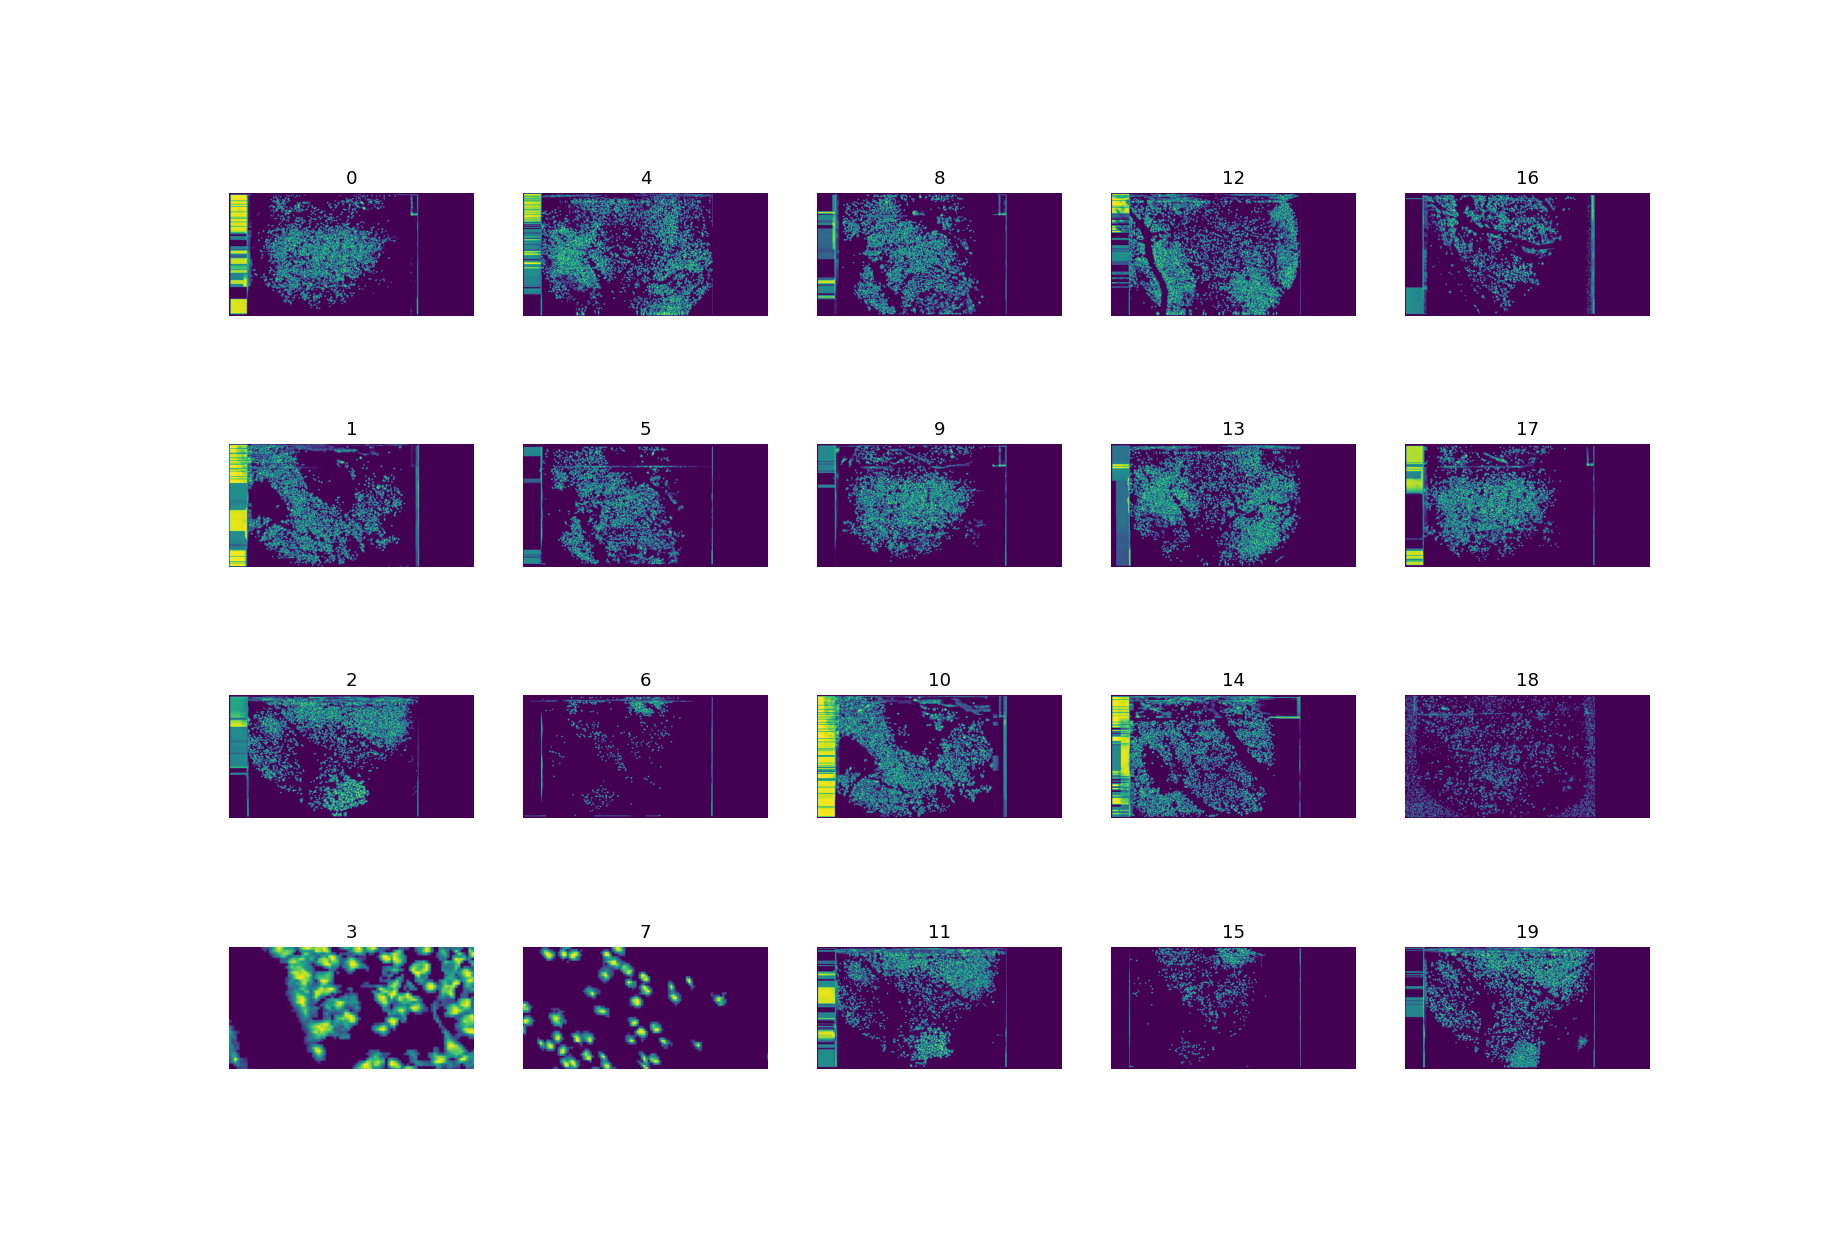

(<Figure size 640x480 with 20 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'16'}>],
        [<AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'17'}>],
        [<AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'14'}>,
         <AxesSubplot:title={'center':'18'}>],
        [<AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'11'}>,
         <AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'19'}>]], dtype=object))

In [51]:
%matplotlib notebook

plotting_helpers.plot_image_grid(
    images = FOVs,
    grid_shape = (4, 5),
    labels = range(0,len(FOVs))
)

## OPTIONAL (end)

In [53]:
bad_sessions = []
n_sessions = len(stats)
good_sessions = np.arange(n_sessions)
good_sessions = np.array(good_sessions[np.isin(good_sessions, bad_sessions, invert=True)])

In [54]:
sf_raw = [
    statFile_to_spatialFootprints(
        statFile=stat, 
        out_height_width=[36,36],
        max_footprint_width=1441, 
        plot_pref=False, 
        one_indexed=True
    ) for stat in stats
]

In [55]:
sf_all = [val for ii,val in enumerate(sf_raw) if ii in good_sessions]

In [56]:
sf_all_concat = np.concatenate(sf_all, axis=0)

rescale to ~250 non-zero pixels average

In [57]:
import PIL

In [58]:
import torch, torchvision

In [59]:
def resize_affine(img, scale):
    return torchvision.transforms.functional.affine(
#         img=torch.as_tensor(img[None,...]),
        img=PIL.Image.fromarray(img),
        angle=0, translate=[0,0], shear=0,
        scale=scale,
        interpolation=torchvision.transforms.InterpolationMode.BICUBIC
    )

In [60]:
sf_concat_rs = np.stack([np.array(resize_affine(img, scale=2.1)) for img in sf_all_concat], axis=0)

In [61]:
sf_concat_rs.shape

(850519, 36, 36)

<IPython.core.display.Javascript object>


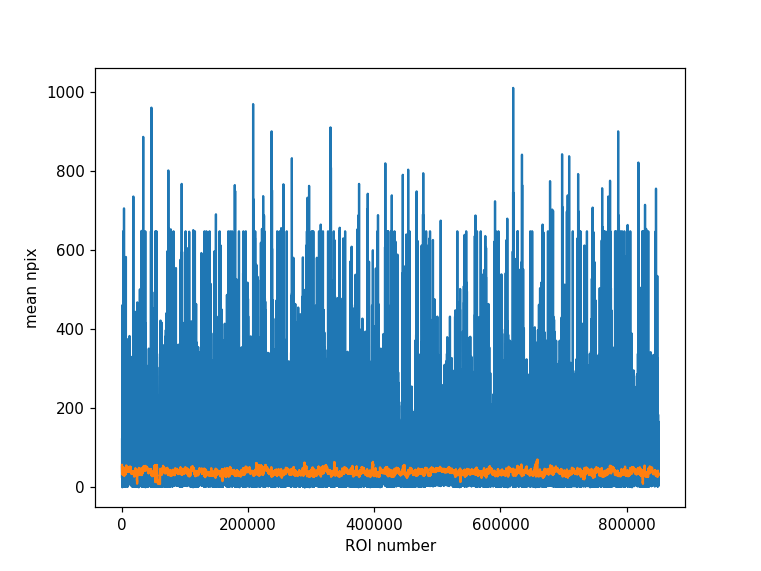

<IPython.core.display.Javascript object>


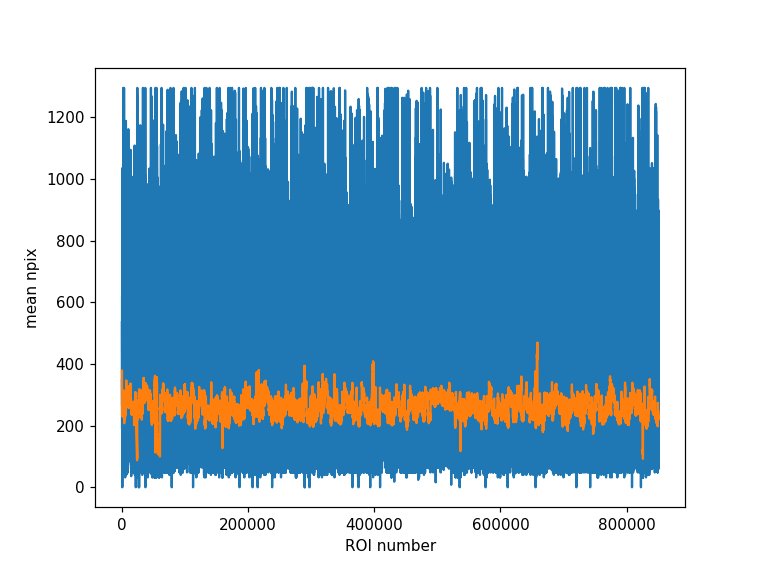

In [62]:
%matplotlib notebook

plt.figure()
plt.plot(np.sum(sf_all_concat > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(sf_all_concat > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

plt.figure()
plt.plot(np.sum(sf_concat_rs > 0, axis=(1,2)))
plt.plot(scipy.signal.savgol_filter(np.sum(sf_concat_rs > 0, axis=(1,2)), 501, 3))
plt.xlabel('ROI number');
plt.ylabel('mean npix');

<IPython.core.display.Javascript object>


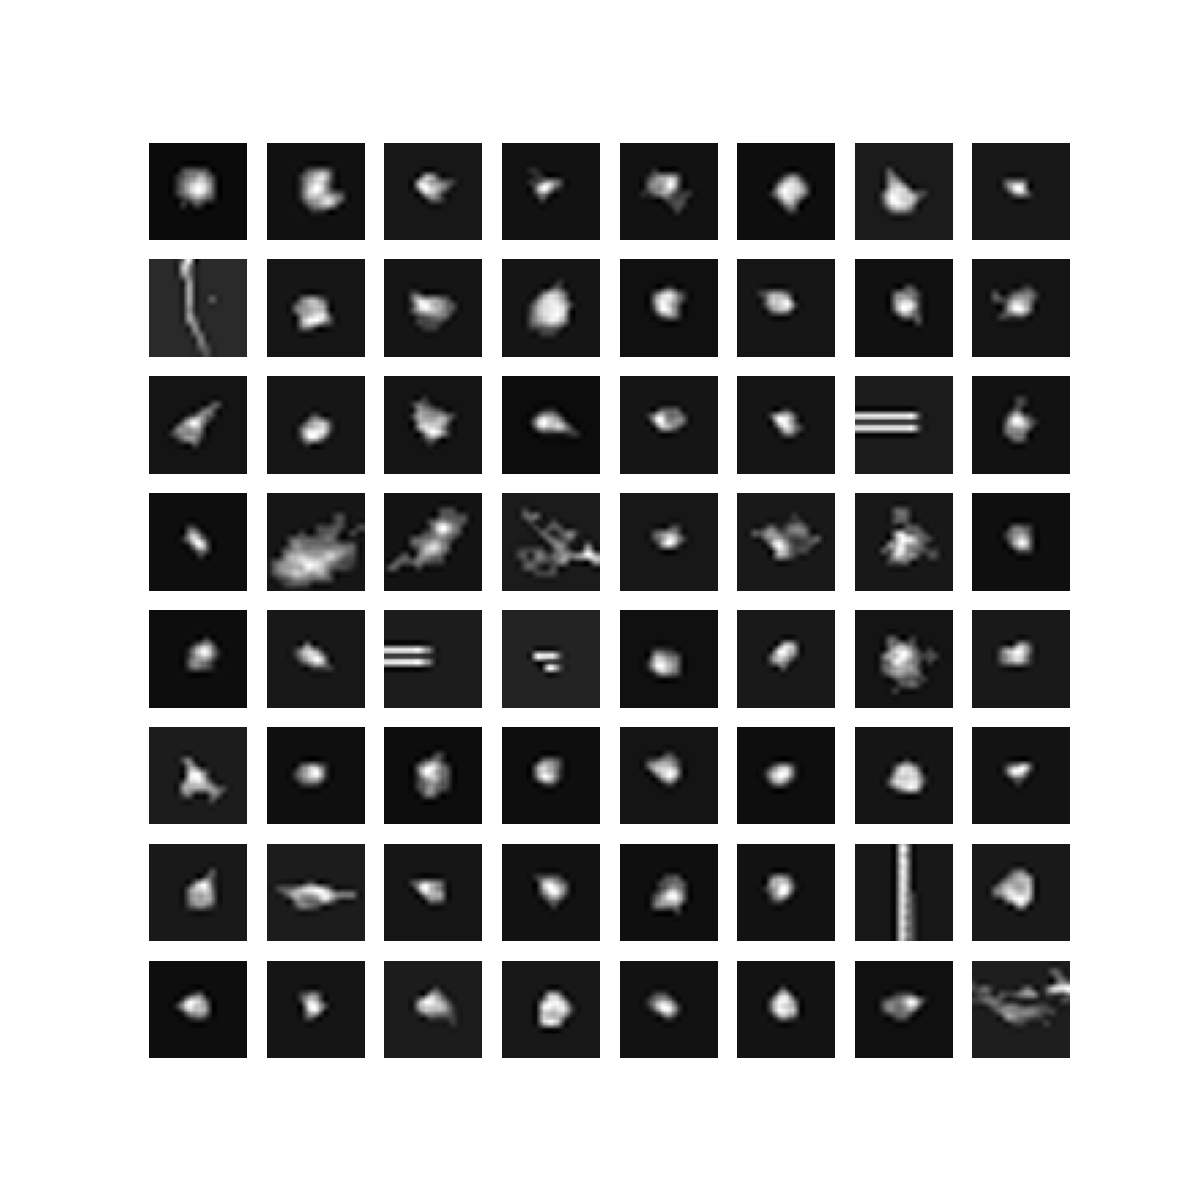

In [65]:
%matplotlib notebook
plotting_helpers.plot_image_grid(images=sf_concat_rs[np.random.randint(0, sf_concat_rs.shape[0], size=1000)],
#                                 labels=SYTlabels[20000:],
                                grid_shape=(8,8),
                                show_axis='off',
                                cmap='gray',
                                kwargs_subplots={'figsize':(10,10)},
                                kwargs_imshow={'interpolation':'antialiased'});

## Saving

In [151]:
h5_handling.simple_save({
    'NNmasks': sf_concat_rs,
    },
        path='/media/rich/bigSSD/other lab data/Andermann_lab/Nghia_ROIs/NNmasks.h5',
        verbose=True)

==== Successfully wrote h5 file. Displaying h5 hierarchy ====
1. NNmasks:   shape=(43325, 36, 36) , dtype=float32


## Duplicates analysis

In [83]:
gaus = featurization.gaussian_kernel_2D(center = (51, 51), image_size = (101, 101), sig = 20)

plt.figure()
plt.imshow(gaus)

In [96]:
def torch_conv2d(img, kernel):
    return torch.nn.functional.conv2d(img[None,None,...], kernel[None,None,...], bias=None, stride=1, padding='same', dilation=1, groups=1)

In [110]:
from tqdm.notebook import tqdm
FOVs_conv = [torch_conv2d(torch.as_tensor(sfFOV, device='cuda:0').max(0)[0], torch.as_tensor(gaus, dtype=torch.float32, device='cuda:0')).cpu().numpy().squeeze() for sfFOV in tqdm(sfFOVs)]

  0%|          | 0/254 [00:00<?, ?it/s]

In [128]:
FOVs_conv_ds = [image_processing.bin_array(FOV, bin_widths=[8,8], method='post_crop') for FOV in FOVs_conv]

In [130]:
FOVs_conv_flat = np.array([FOV.reshape(-1) for FOV in FOVs_conv_ds])

In [131]:
FOVs_conv_flat.shape

(254, 8192)

In [146]:
import umap 

umap_obj = umap.UMAP(    
    n_neighbors=4,
    n_components=1,
    metric='euclidean',
    metric_kwds=None,
    output_metric='euclidean',
    output_metric_kwds=None,
    n_epochs=None,
    learning_rate=1.0,
    init='spectral',
    min_dist=0.1,
    spread=1.0,
    low_memory=True,
    n_jobs=-1,
    set_op_mix_ratio=1.0,
    local_connectivity=1.0,
    repulsion_strength=1.0,
    negative_sample_rate=5,
    transform_queue_size=4.0,
    a=None,
    b=None,
    random_state=None,
    angular_rp_forest=False,
    target_n_neighbors=-1,
    target_metric='categorical',
    target_metric_kwds=None,
    target_weight=0.5,
    transform_seed=42,
    transform_mode='embedding',
    force_approximation_algorithm=False,
    verbose=False,
    tqdm_kwds=None,
    unique=False,
    densmap=False,
    dens_lambda=2.0,
    dens_frac=0.3,
    dens_var_shift=0.1,
    output_dens=False,
    disconnection_distance=None,
    precomputed_knn=(None, None, None),
)

In [147]:
embedding = umap_obj.fit_transform(FOVs_conv_flat)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/rapids-21.12/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<IPython.core.display.Javascript object>


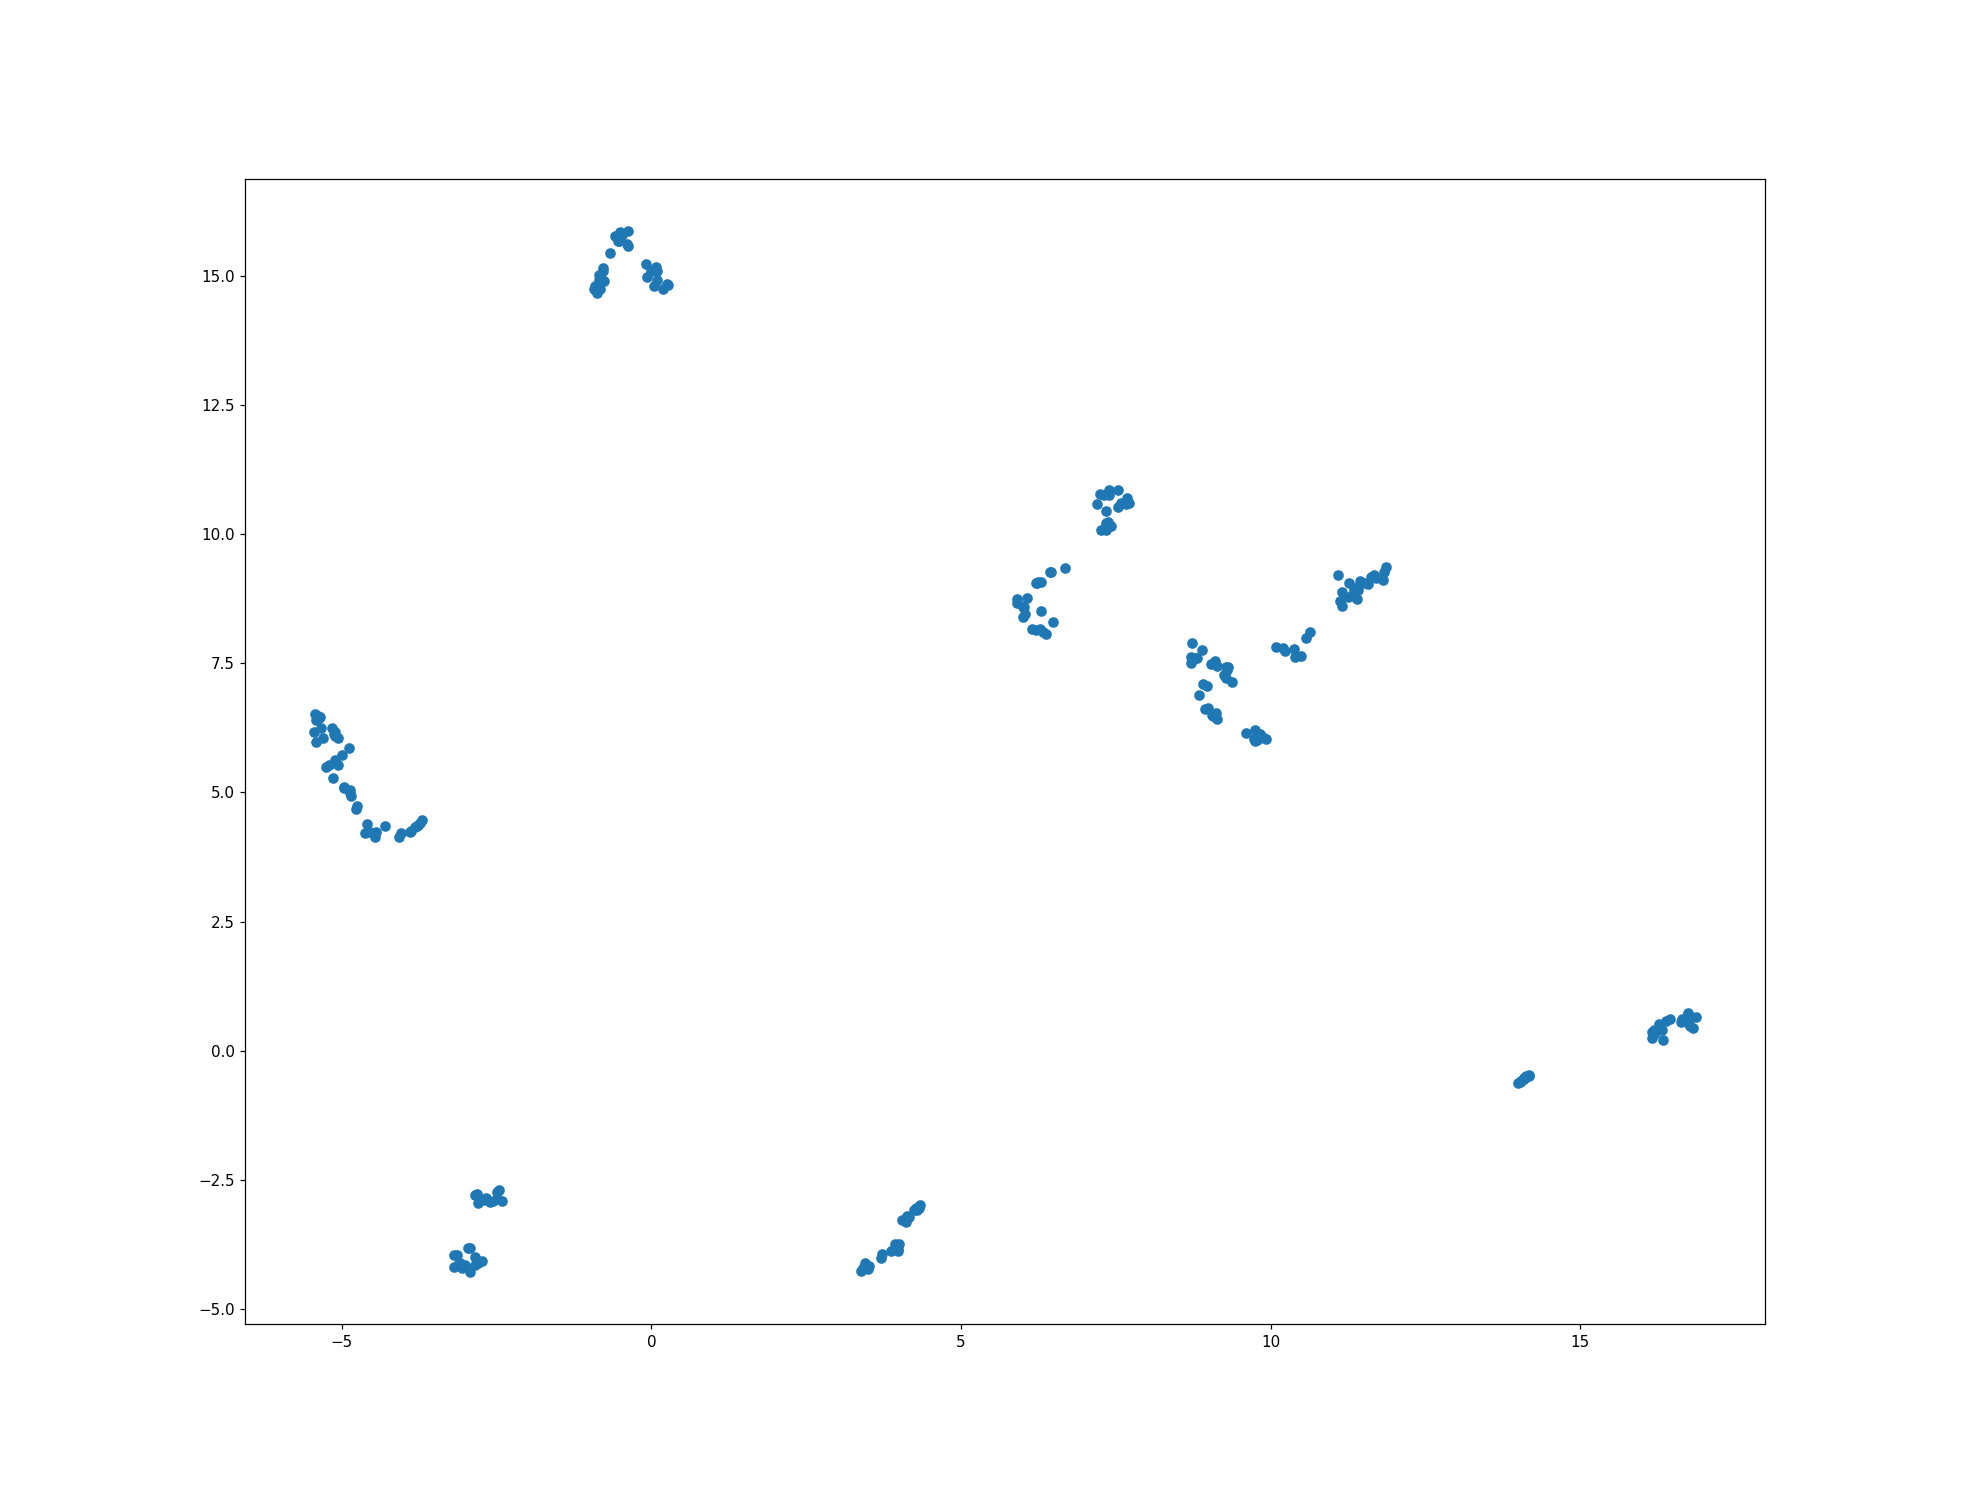

In [143]:
plt.figure()
plt.scatter(embedding[:,0], embedding[:,1])

<IPython.core.display.Javascript object>


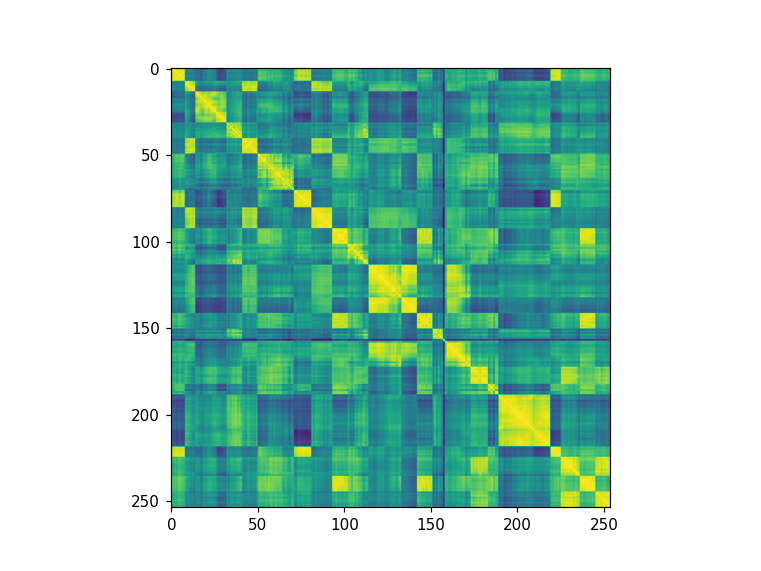

In [151]:
plt.figure()
plt.imshow(similarity.pairwise_similarity(FOVs_conv_flat.T[:, np.argsort(embedding.squeeze())]))

<IPython.core.display.Javascript object>


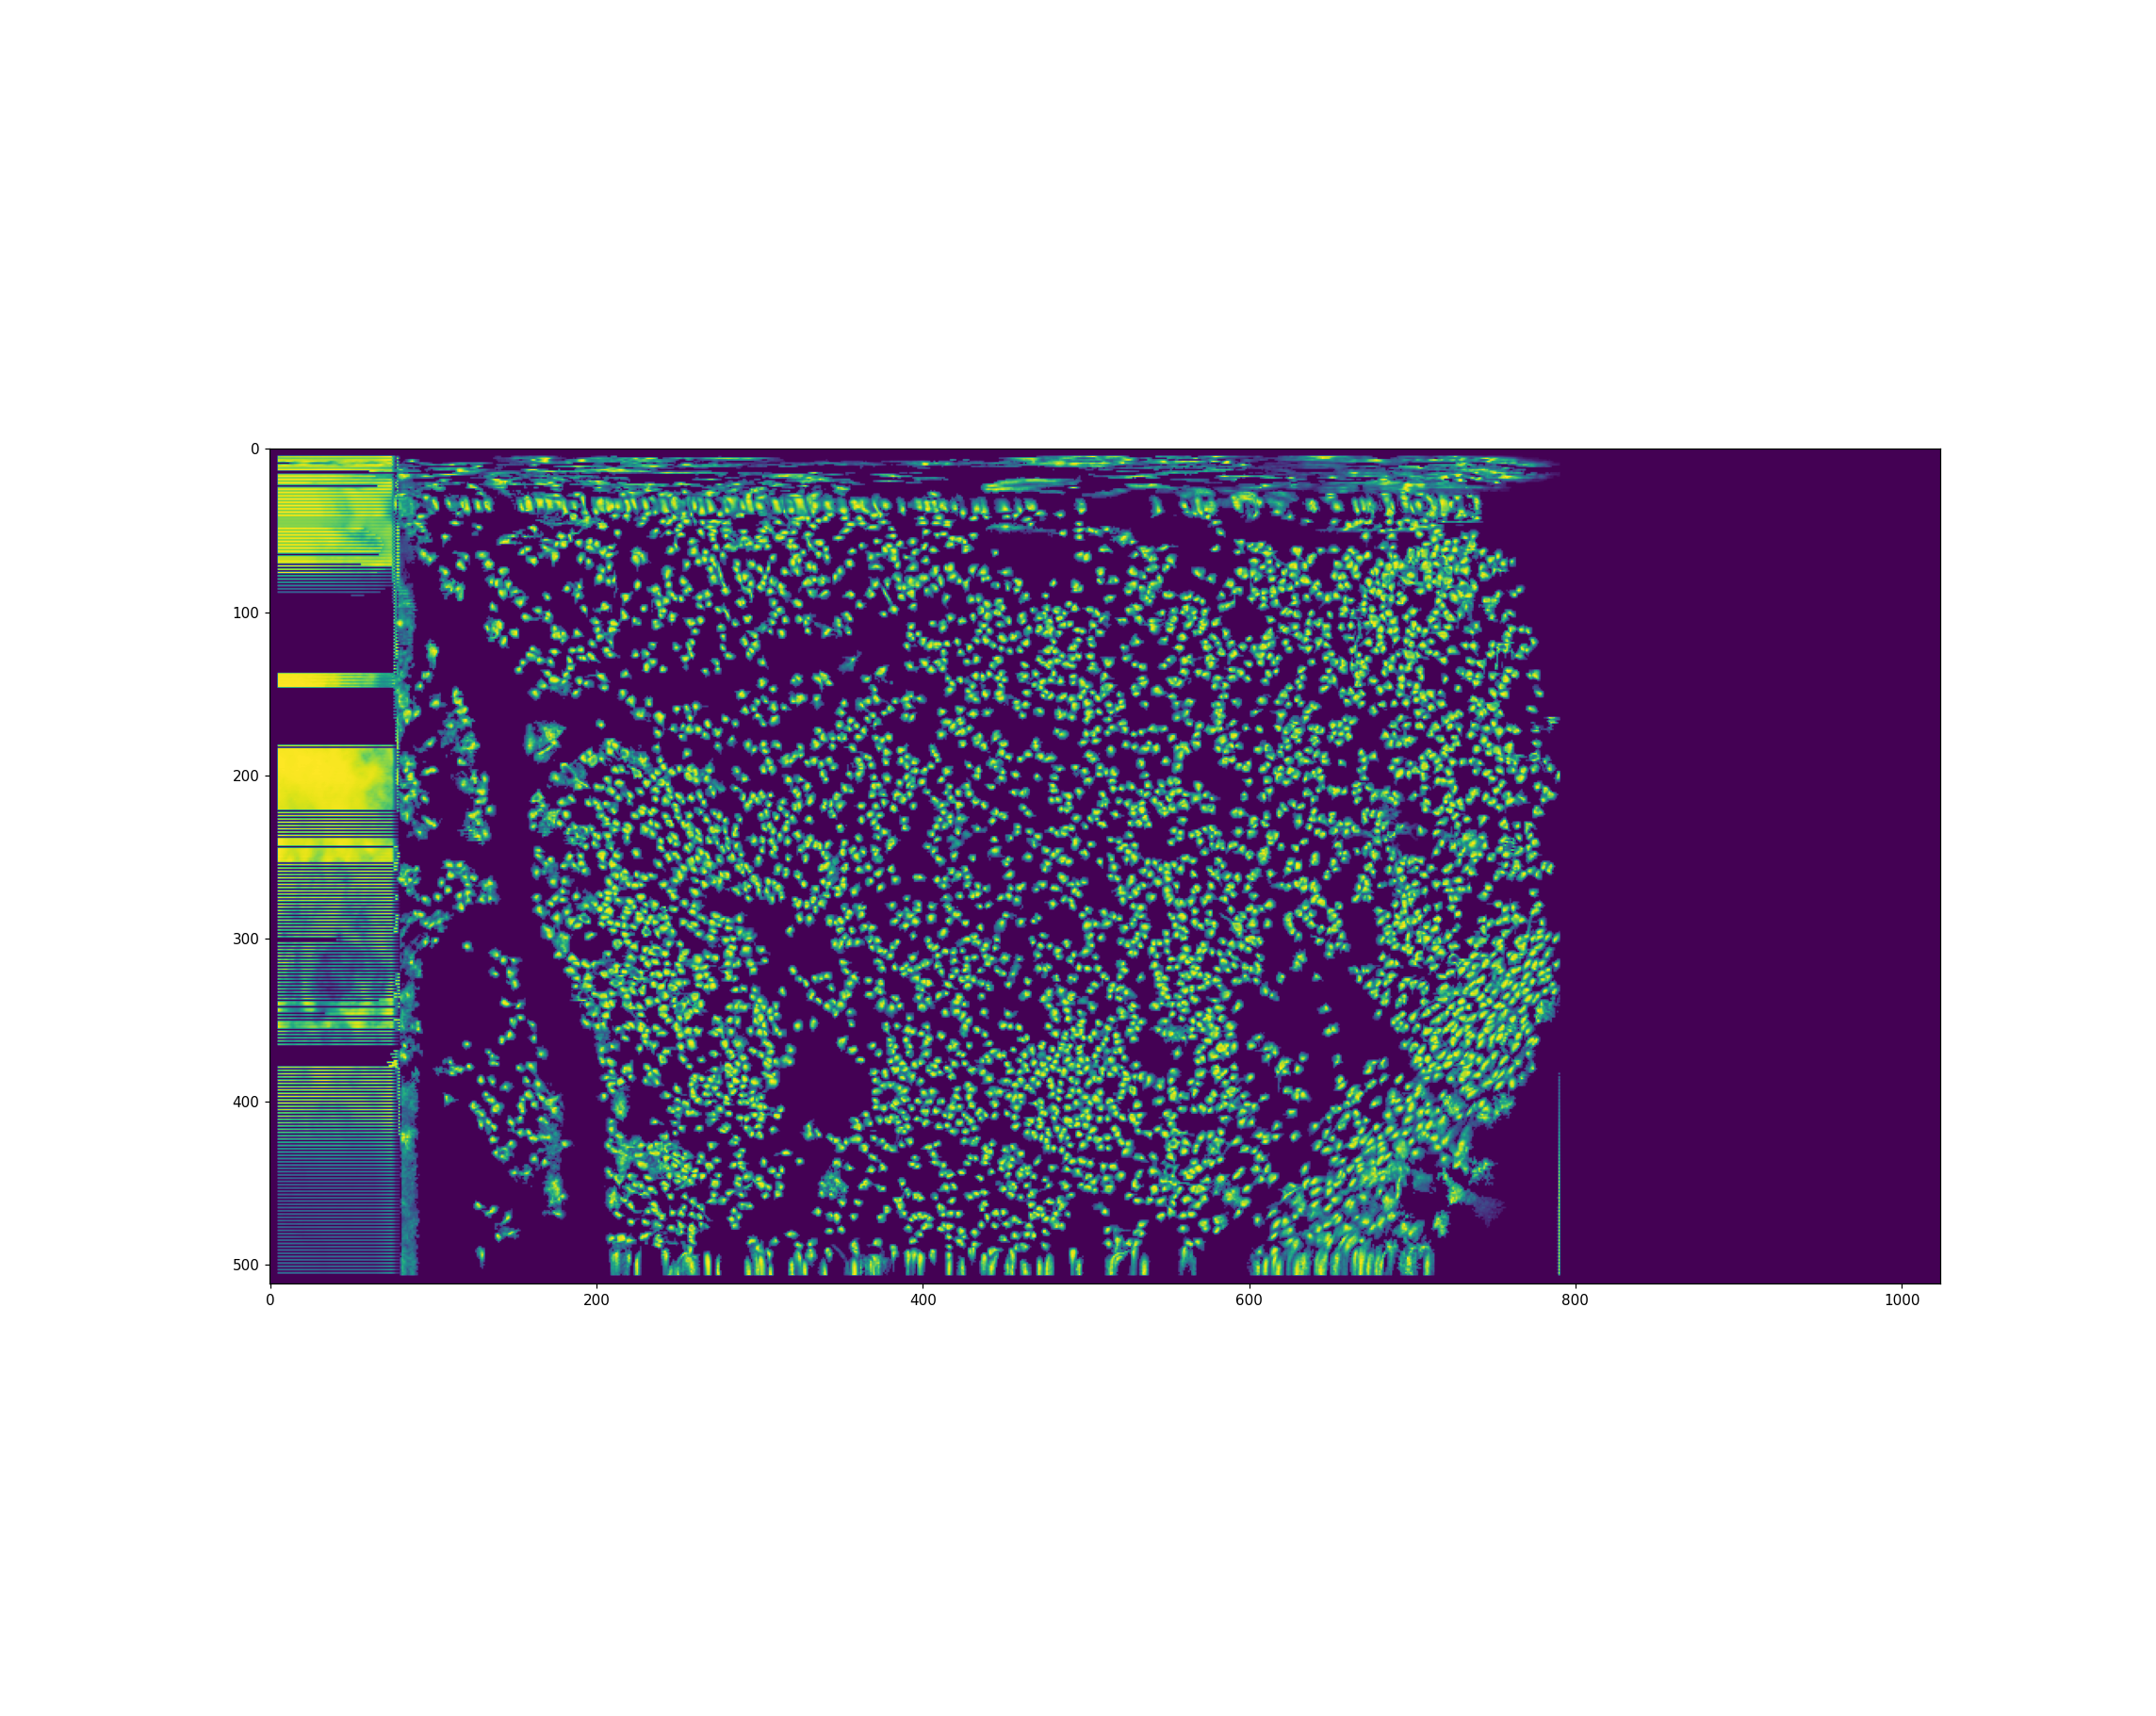

interactive(children=(IntSlider(value=0, description='i_frame', max=253), Output()), _dom_classes=('widget-int…

In [160]:
plotting_helpers.display_toggle_image_stack(np.array(FOVs)[ np.argsort(embedding.squeeze())])

In [158]:
%matplotlib notebook
plotting_helpers.plot_image_grid(images=np.array(FOVs)[ np.argsort(embedding.squeeze())],
#                                 labels=SYTlabels[20000:],
                                grid_shape=(8,8),
                                show_axis='off',
                                cmap='gray',
                                kwargs_subplots={'figsize':(10,10)},
                                kwargs_imshow={'interpolation':'antialiased'});

<IPython.core.display.Javascript object>